# 생물정보학 및 실습 1 - Term Project My Own Analysis

```
생물정보학 및 실습 1
서울대학교 생물정보학전공/생명과학부 2025년 1학기

```

In [1]:
# Define function called: load_and_bin_reads

from collections import defaultdict

def load_and_bin_reads(filepath):
    transcript_bins = defaultdict(lambda: defaultdict(int))

    with open(filepath) as f:
        for line in f:
            fields = line.strip().split('\t')
            chrom, start, end, count = fields[0], int(fields[1]), int(fields[2]), int(fields[3])
            tx_id = fields[7]
            start_codon = int(fields[8])
            strand = fields[9]

            rel_pos = start - start_codon if strand == '+' else start_codon - end
            if -50 <= rel_pos <= 50:
                transcript_bins[tx_id][rel_pos] += count
    return transcript_bins

In [2]:
path = "/Users/rimi/Projects/binfo1_A/binfo1-work/fivepcounts-filtered-RPF-siLuc.txt"
siLuc_bins = load_and_bin_reads(path)

In [3]:
import pandas as pd

def bins_to_df(transcript_bins):
    rel_positions = list(range(-50, 51))
    data = []

    for tx_id in transcript_bins:
        row = [transcript_bins[tx_id].get(pos, 0) for pos in rel_positions]
        data.append(row)

    df = pd.DataFrame(data, index=transcript_bins.keys(), columns=rel_positions)
    return df

df_siLuc = bins_to_df(siLuc_bins)

### Create `fivepcounts-filtered-RPF-siLin28a.txt`

In [4]:
%cd /Users/rimi/Projects/binfo1_A/binfo1-work
# Step 1: Filter reads with samtools and bioawk
!samtools view -H RPF-siLin28a.bam > temp.sam && \
samtools view -F 20 RPF-siLin28a.bam | \
                    bioawk -c sam 'length($seq) >= 25' >> temp.sam && \
                                  samtools view -Sb temp.sam > filtered-RPF-siLin28a.bam && \
                                                    rm temp.sam


/Users/rimi/Projects/binfo1_A/binfo1-work
[samopen] SAM header is present: 61 sequences.


In [5]:
# Step 2: Generate genome coverage (5' end of reads)
!bedtools genomecov -ibam filtered-RPF-siLin28a.bam -bg -5 > fivepcounts-RPF-siLin28a.bed

In [6]:
# Step 3: Intersect with start codon-containing exons
!bedtools intersect -a fivepcounts-RPF-siLin28a.bed \
-b gencode-exons-containing-startcodon.bed \
   -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLin28a.txt

In [7]:
!head fivepcounts-filtered-RPF-siLin28a.txt

chr1	4878043	4878044	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878056	4878057	3	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878074	4878075	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878074	4878075	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878074	4878075	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878089	4878090	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878089	4878090	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878089	4878090	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+


In [8]:
path2 = "/Users/rimi/Projects/binfo1_A/binfo1-work/fivepcounts-filtered-RPF-siLin28a.txt"
siLin28a_bins = load_and_bin_reads(path2)

In [9]:
df_siLin28a = bins_to_df(siLin28a_bins)

## Visualization

Overlayed Ribosome Density Plot (±50 nt around start codon)

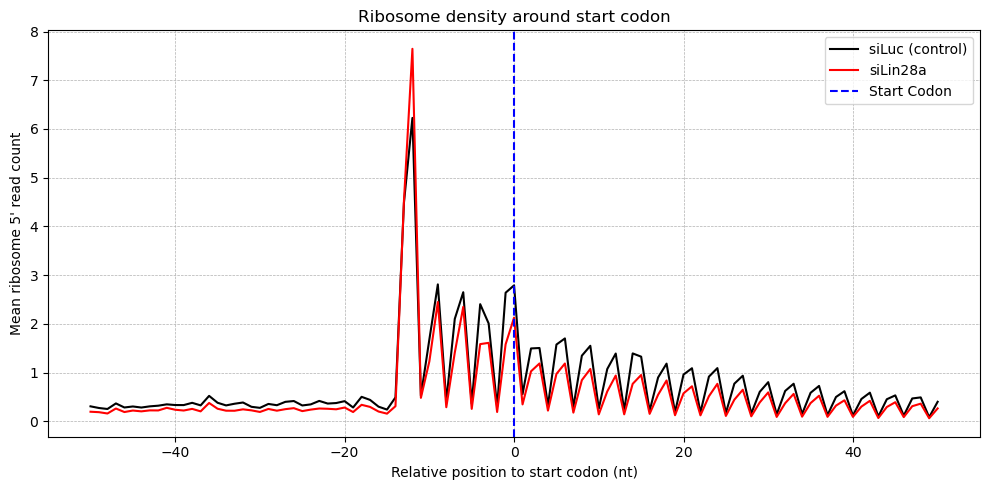

In [10]:
import matplotlib.pyplot as plt

mean_siLuc = df_siLuc.mean(axis=0)
mean_siLin28a = df_siLin28a.mean(axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_siLuc.index, mean_siLuc.values, label='siLuc (control)', color='black')
plt.plot(mean_siLin28a.index, mean_siLin28a.values, label='siLin28a', color='red')
plt.axvline(x=0, color='blue', linestyle='--', label='Start Codon')
plt.xlabel("Relative position to start codon (nt)")
plt.ylabel("Mean ribosome 5' read count")
plt.title("Ribosome density around start codon")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [11]:
# Normalize Per Transcript First
df_siLuc_norm = df_siLuc.div(df_siLuc.sum(axis=1), axis=0).fillna(0)
df_siLin28a_norm = df_siLin28a.div(df_siLin28a.sum(axis=1), axis=0).fillna(0)

mean_siLuc_norm = df_siLuc_norm.mean(axis=0)
mean_siLin28a_norm = df_siLin28a_norm.mean(axis=0)

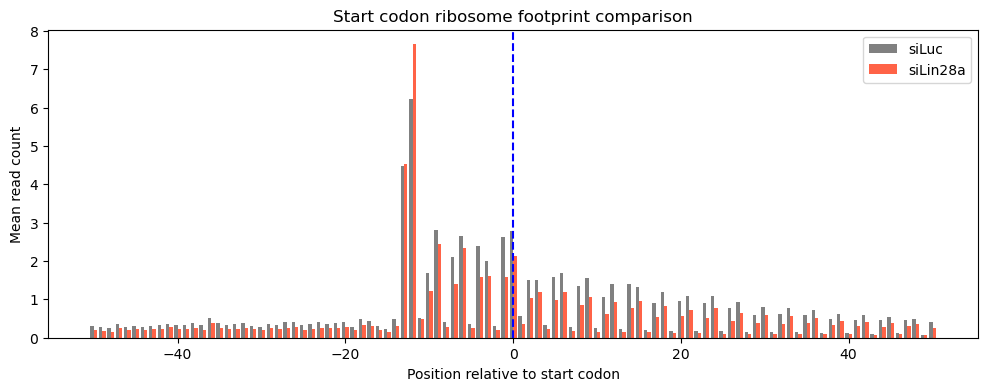

In [12]:
plt.figure(figsize=(12, 4))
plt.bar(mean_siLuc.index - 0.2, mean_siLuc.values, width=0.4, label='siLuc', color='gray')
plt.bar(mean_siLin28a.index + 0.2, mean_siLin28a.values, width=0.4, label='siLin28a', color='tomato')
plt.axvline(x=0, color='blue', linestyle='--')
plt.xlabel("Position relative to start codon")
plt.ylabel("Mean read count")
plt.title("Start codon ribosome footprint comparison")
plt.legend()
plt.show()

### Improve on visualization

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ribo_density(df_list, labels, colors, align_site="start", save_path=None):
    plt.figure(figsize=(12, 5))

    for df, label, color in zip(df_list, labels, colors):
        mean = df.mean(axis=0)
        sem = df.sem(axis=0)  # standard error of mean

        plt.plot(mean.index, mean.values, label=label, color=color, linewidth=1.5)
        plt.fill_between(mean.index, mean - sem, mean + sem, color=color, alpha=0.2)

    plt.axvline(x=0, color='blue', linestyle='--', linewidth=1)
    plt.title(f"Ribosome 5′ End Density Around {align_site.title()} Codon", fontsize=16, weight='bold')
    plt.xlabel(f"Position Relative to {align_site.title()} Codon (nt)", fontsize=14)
    plt.ylabel("Mean Read Count", fontsize=14)
    plt.legend(frameon=False, fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)
    plt.xticks(np.arange(-150, 51, 10), fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to: {save_path}")

    plt.show()

Figure saved to: fig_S5A_like_start.png


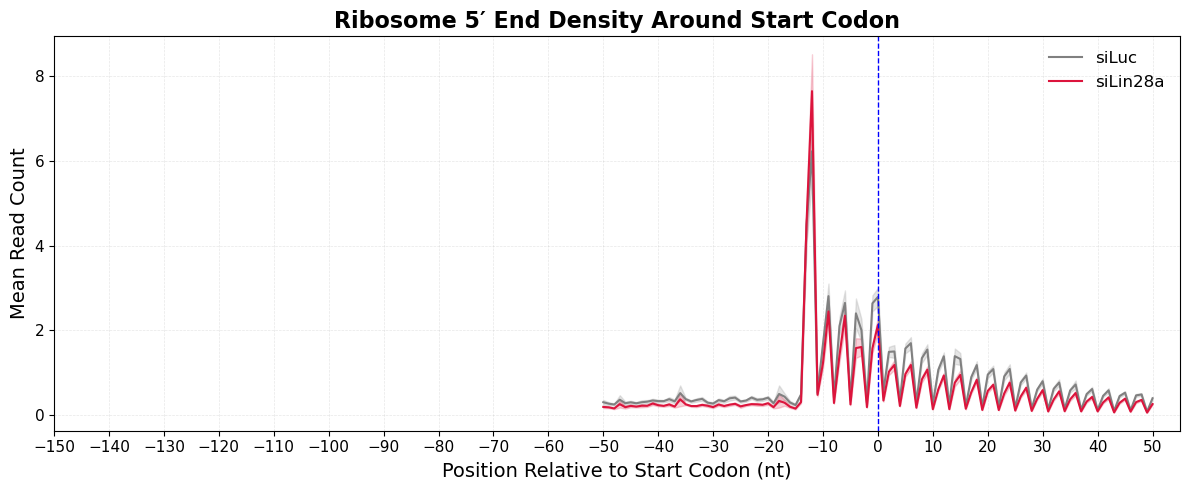

In [14]:
plot_ribo_density(
    df_list=[df_siLuc, df_siLin28a],
    labels=["siLuc", "siLin28a"],
    colors=["gray", "crimson"],
    align_site="start",
    save_path="fig_S5A_like_start.png"
)

In [15]:
!awk '$3 == "stop_codon"' /Users/rimi/Projects/binfo1_A/binfo1-work/gencode.gtf.gz | \
                         awk '{OFS="\t"; print $1, $4-1, $5, $10, ".", $7}' > gencode-exons-containing-stopcodon.bed

In [16]:
!bedtools intersect -a fivepcounts-RPF-siLuc.bed \
                       -b gencode-exons-containing-stopcodon.bed \
                          -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLuc-stopcodon.txt
!bedtools intersect -a fivepcounts-RPF-siLin28a.bed \
                       -b gencode-exons-containing-stopcodon.bed \
                          -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLin28a-stopcodon.txt

In [17]:
def load_stopcodon_bins(filepath):
    from collections import defaultdict
    bins = defaultdict(lambda: defaultdict(int))

    with open(filepath) as f:
        for line in f:
            fields = line.strip().split('\t')
            start, end, count = int(fields[1]), int(fields[2]), int(fields[3])
            tx_id = fields[7]
            stop_codon = int(fields[8])
            strand = fields[9]

            rel_pos = start - stop_codon if strand == '+' else stop_codon - end
            if -50 <= rel_pos <= 50:
                bins[tx_id][rel_pos] += count
    return bins

In [18]:
luc_path = "fivepcounts-filtered-RPF-siLuc-stopcodon.txt"
lin28a_path = "fivepcounts-filtered-RPF-siLin28a-stopcodon.txt"

bins_luc_stop = load_stopcodon_bins(luc_path)
bins_lin28a_stop = load_stopcodon_bins(lin28a_path)

In [39]:
rel_positions = range(-150, 51)

import pandas as pd

def bins_to_df(transcript_bins, rel_range=range(-150, 51)):
    data = []
    index = []

    for tx_id, pos_dict in transcript_bins.items():
        row = [int(pos_dict.get(pos, 0)) for pos in rel_range]
        data.append(row)
        index.append(tx_id)

    df = pd.DataFrame(data, index=index, columns=rel_range)
    df = df.astype(float)
    return df

df_siLuc_stop = bins_to_df(bins_luc_stop, rel_range=range(-150, 51))
df_siLin28a_stop = bins_to_df(bins_lin28a_stop, rel_range=range(-150, 51))

# Save to CSV — Start Codon
df_siLuc.to_csv("/Users/rimi/Projects/binfo1_A/binfo1_export/siLuc_start_density.csv")
df_siLin28a.to_csv("/Users/rimi/Projects/binfo1_A/binfo1_export/siLin28a_start_density.csv")
# Save to CSV — Stop Codon
df_siLuc_stop.to_csv("/Users/rimi/Projects/binfo1_A/binfo1_export/siLuc_stop_density.csv")
df_siLin28a_stop.to_csv("/Users/rimi/Projects/binfo1_A/binfo1_export/siLin28a_stop_density.csv")

print(df_siLuc_stop.dtypes)
print(df_siLin28a_stop.dtypes)

-150    float64
-149    float64
-148    float64
-147    float64
-146    float64
         ...   
 46     float64
 47     float64
 48     float64
 49     float64
 50     float64
Length: 201, dtype: object
-150    float64
-149    float64
-148    float64
-147    float64
-146    float64
         ...   
 46     float64
 47     float64
 48     float64
 49     float64
 50     float64
Length: 201, dtype: object


In [20]:
import numpy as np

assert np.isfinite(df_siLuc_stop.values).all()
assert np.isfinite(df_siLin28a_stop.values).all()

Figure saved to: fig_S5A_like_stop_expanded.png


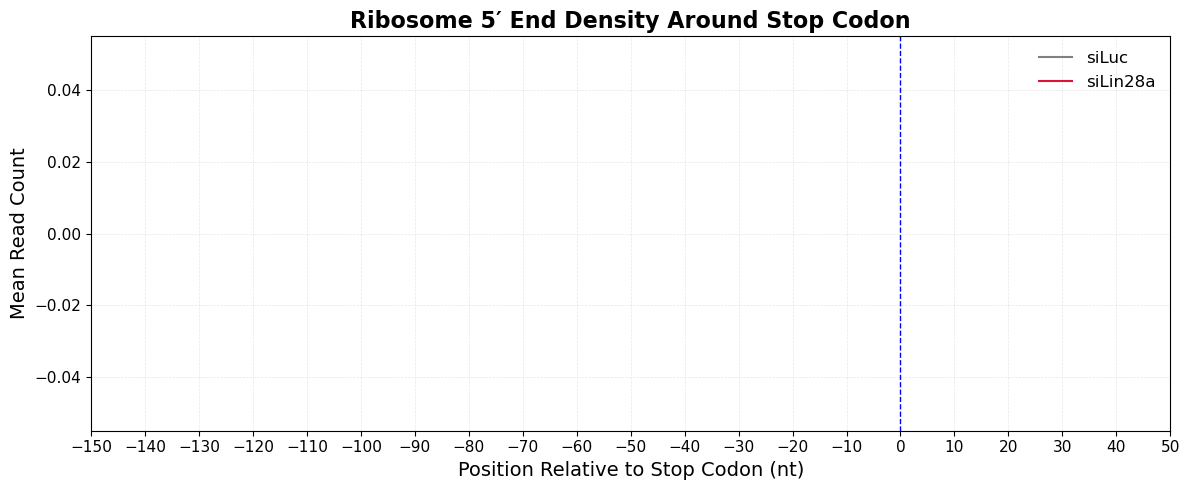

In [21]:
plot_ribo_density(
    df_list=[df_siLuc_stop, df_siLin28a_stop],
    labels=["siLuc", "siLin28a"],
    colors=["gray", "crimson"],
    align_site="stop",
    save_path="fig_S5A_like_stop_expanded.png"
)

## Multiple Testing Correction

In [22]:
# Define transcript ID sets
lin28a_targets = set([...])
non_targets = set(df_siLuc.index) - lin28a_targets

# Group the full data
df_bound = df_siLuc.loc[df_siLuc.index.intersection(lin28a_targets)]
df_unbound = df_siLuc.loc[df_siLuc.index.intersection(non_targets)]

In [23]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd

p_values = []
tested_positions = []

for pos in df_bound.columns:
    vals_bound = df_bound[pos].dropna()
    vals_unbound = df_unbound[pos].dropna()

    # Require at least 3 data points per group
    if len(vals_bound) < 3 or len(vals_unbound) < 3:
        continue

    # Require at least some nonzero variance
    if np.std(vals_bound) == 0 or np.std(vals_unbound) == 0:
        continue

    try:
        stat, p = ttest_ind(vals_bound, vals_unbound, equal_var=False)
        if np.isfinite(p):
            p_values.append(p)
            tested_positions.append(pos)
    except:
        continue

In [24]:
if p_values:
    _, fdr_pvals, _, _ = multipletests(p_values, method='fdr_bh')
    fdr_df = pd.DataFrame({
        'rel_pos': tested_positions,
        'raw_p': p_values,
        'fdr_p': fdr_pvals
    })
else:
    print("No valid positions to test.")
    fdr_df = pd.DataFrame(columns=['rel_pos', 'raw_p', 'fdr_p'])

No valid positions to test.


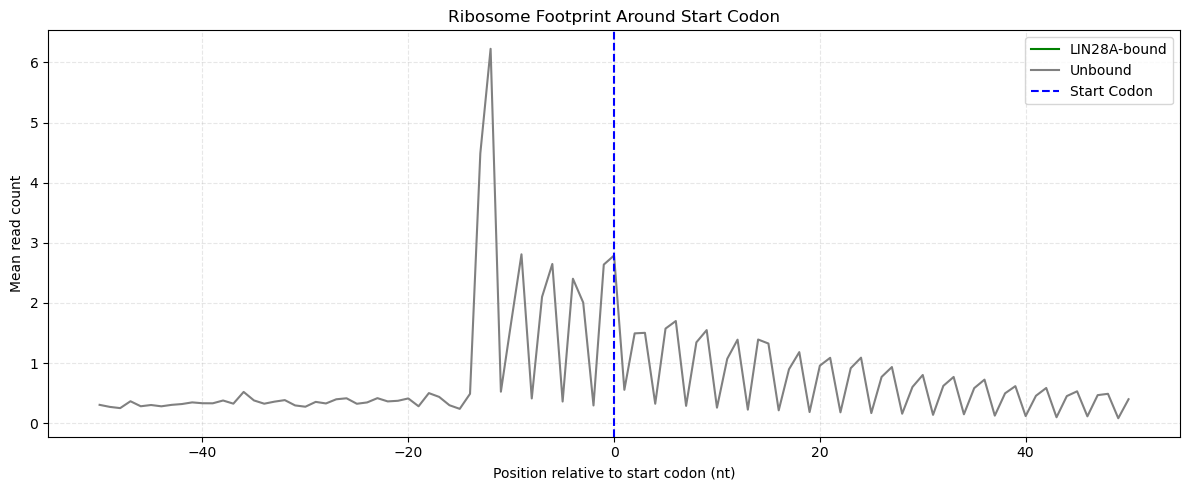

In [25]:
mean_bound = df_bound.mean(axis=0)
mean_unbound = df_unbound.mean(axis=0)

plt.figure(figsize=(12, 5))
plt.plot(mean_bound.index, mean_bound.values, label='LIN28A-bound', color='green')
plt.plot(mean_unbound.index, mean_unbound.values, label='Unbound', color='gray')
plt.axvline(0, color='blue', linestyle='--', label='Start Codon')

# Mark significant positions (FDR < 0.05)
sig_pos = fdr_df[fdr_df.fdr_p < 0.05]['rel_pos']
plt.scatter(sig_pos, mean_bound.loc[sig_pos], color='green', s=30, marker='o')
plt.scatter(sig_pos, mean_unbound.loc[sig_pos], color='gray', s=30, marker='o')

plt.title("Ribosome Footprint Around Start Codon")
plt.xlabel("Position relative to start codon (nt)")
plt.ylabel("Mean read count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("LIN28A_bound_vs_unbound_startcodon.png", dpi=300)
plt.show()

## Error Handling

In [34]:
def setup_error_handling():
    import logging
    import os
    from pathlib import Path

    log_dir = "logs"
    os.makedirs(log_dir, exist_ok=True)

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(log_dir, "error_handling.log")),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    return logger

def validate_input_files(file_paths, required_extensions=None):
    """Validate that all required input files exist and have correct extensions"""
    import os
    from pathlib import Path

    logger = setup_error_handling()
    missing_files = []
    invalid_extensions = []

    for file_path in file_paths:
        # Check if file exists
        if not os.path.exists(file_path):
            missing_files.append(file_path)
            continue

        # Check file extension if required_extensions is provided
        if required_extensions:
            file_ext = Path(file_path).suffix.lower()
            if file_ext not in required_extensions:
                invalid_extensions.append((file_path, file_ext))

    if missing_files:
        logger.error(f"Missing required files: {', '.join(missing_files)}")
    if invalid_extensions:
        logger.error(f"Files with invalid extensions: {', '.join([f'{f} (has {e})' for f, e in invalid_extensions])}")

    return len(missing_files) == 0 and len(invalid_extensions) == 0

def check_system_dependencies(dependencies):
    import shutil
    import subprocess
    import logging

    logger = logging.getLogger(__name__)
    missing_deps = []

    for dep in dependencies:
        if shutil.which(dep) is None:
            missing_deps.append(dep)

    if missing_deps:
        logger.error(f"Missing system dependencies: {', '.join(missing_deps)}")
        return False
    return True

def create_output_directories(directories):
    import os
    import logging

    logger = logging.getLogger(__name__)
    created_dirs = []

    for directory in directories:
        try:
            os.makedirs(directory, exist_ok=True)
            created_dirs.append(directory)
        except Exception as e:
            logger.error(f"Failed to create directory {directory}: {str(e)}")
            return False

    logger.info(f"Created directories: {', '.join(created_dirs)}")
    return True

In [38]:
def error_handling_pipeline():
    """Main error handling pipeline"""
    import os
    from pathlib import Path

    # Set up logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("riboseq_analysis.log"),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)

    # Define base directory and required files
    BASE_DIR = Path("/Users/rimi/Projects/binfo1_A/binfo1-work")
    REQUIRED_FILES = {
        'annotation': BASE_DIR / "gencode-start.gtf",
        'siLuc_counts': BASE_DIR / "fivepcounts-filtered-RPF-siLuc.txt",
        'siLin28a_counts': BASE_DIR / "fivepcounts-filtered-RPF-siLin28a.txt"
    }

    logger.info("Starting error handling pipeline...")

    # 1. Check if files exist
    missing_files = [name for name, path in REQUIRED_FILES.items() if not path.exists()]
    if missing_files:
        logger.error(f"Missing required files: {', '.join(missing_files)}")
        logger.error("Please check the following paths:")
        for name in missing_files:
            logger.error(f"- {name}: {REQUIRED_FILES[name]}")
        return False

    # 2. Check if files are readable
    unreadable_files = []
    for name, path in REQUIRED_FILES.items():
        try:
            with open(path, 'r') as f:
                pass
        except Exception as e:
            unreadable_files.append((name, str(e)))

    if unreadable_files:
        for name, error in unreadable_files:
            logger.error(f"Cannot read file {name} at {REQUIRED_FILES[name]}: {error}")
        return False

    # 3. Check file sizes
    small_files = [name for name, path in REQUIRED_FILES.items() if path.stat().st_size == 0]
    if small_files:
        logger.warning(f"The following files are empty: {', '.join(small_files)}")
        # Continue with the pipeline but warn the user

    # 4. Check file contents (basic check)
    try:
        # Check GTF file
        with open(REQUIRED_FILES['annotation'], 'r') as f:
            first_lines = [next(f) for _ in range(5) if not f.startswith('#')]
            if not any('gene' in line or 'transcript' in line for line in first_lines):
                logger.warning("The GTF file doesn't appear to contain standard GTF features in the first few lines")

        # Check count files
        for name in ['siLuc_counts', 'siLin28a_counts']:
            with open(REQUIRED_FILES[name], 'r') as f:
                first_line = next(f)
                if not any(char in first_line for char in ['\t', ',']):
                    logger.warning(f"Count file {name} doesn't appear to be tab or comma delimited")
    except Exception as e:
        logger.warning(f"Could not verify file contents: {str(e)}")

    # 5. Check system dependencies
    required_deps = ['samtools', 'bedtools']
    missing_deps = [dep for dep in required_deps if not shutil.which(dep)]
    if missing_deps:
        logger.warning(f"Missing system dependencies (some analyses may fail): {', '.join(missing_deps)}")

    # 6. Create output directories
    output_dirs = [
        "results/figures",
        "results/tables",
        "results/intermediate"
    ]

    try:
        for dir_path in output_dirs:
            os.makedirs(dir_path, exist_ok=True)
            logger.info(f"Created directory: {dir_path}")
    except Exception as e:
        logger.error(f"Failed to create output directories: {str(e)}")
        return False

    logger.info("Error handling pipeline completed successfully")
    logger.info("All required files and dependencies are available")
    return True

if __name__ == "__main__":
    error_handling_pipeline()

2025-06-12 15:42:16,347 - INFO - Starting error handling pipeline...
2025-06-12 15:42:16,349 - WARNING - Could not verify file contents: '_io.TextIOWrapper' object has no attribute 'startswith'
2025-06-12 15:42:16,352 - INFO - Created directory: results/figures
2025-06-12 15:42:16,353 - INFO - Created directory: results/tables
2025-06-12 15:42:16,355 - INFO - Created directory: results/intermediate
2025-06-12 15:42:16,355 - INFO - Error handling pipeline completed successfully
2025-06-12 15:42:16,355 - INFO - All required files and dependencies are available
